# Replication of results of the article

(c) Charles Le Losq and contributors, 2021-2023
see embedded licence file

This notebook generates figures and values to assess the final performance fo the 10 selected models.

## Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern#, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# for uncertainty calibration
from fortuna.conformal.regression import QuantileConformalRegressor

# neuravi internals
import src.imelt as imelt
import src.utils as utils

# other essentials
import torch, time, h5py

# we will work on GPU or CPU there, depending on availability
device = utils.get_default_device()

/home/charles/anaconda3/envs/ml/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


CUDA AVAILABLE? 
Yes, setting device to cuda


# Loading dataset and models

In [2]:
#
# data are loaded using the data_loader helper.
#
ds = imelt.data_loader()

#
# The 10 models are loaded through a bagging class.
#
neuralmodel = imelt.load_pretrained_bagged(path_viscosity='./data/NKCMAS_viscosity.hdf5',
                                           activation_function=torch.nn.GELU())

#
# Print information about dataset
#
ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 790
Number of unique compositions in training (viscosity): 634
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (entropy): 99
Number of unique compositions in training (entropy): 79
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (refractive index): 610
Number of unique compositions in training (refractive index): 492
Dataset separations are 0.81 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass density): 668
Number of unique compositions in training (glass density): 535
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass elastic modulus): 1006
Number of unique compositions in training (glass elastic modulus): 808
Dataset separations are 0.80 in train, 0.10 in valid, 0.1

# Figure 1

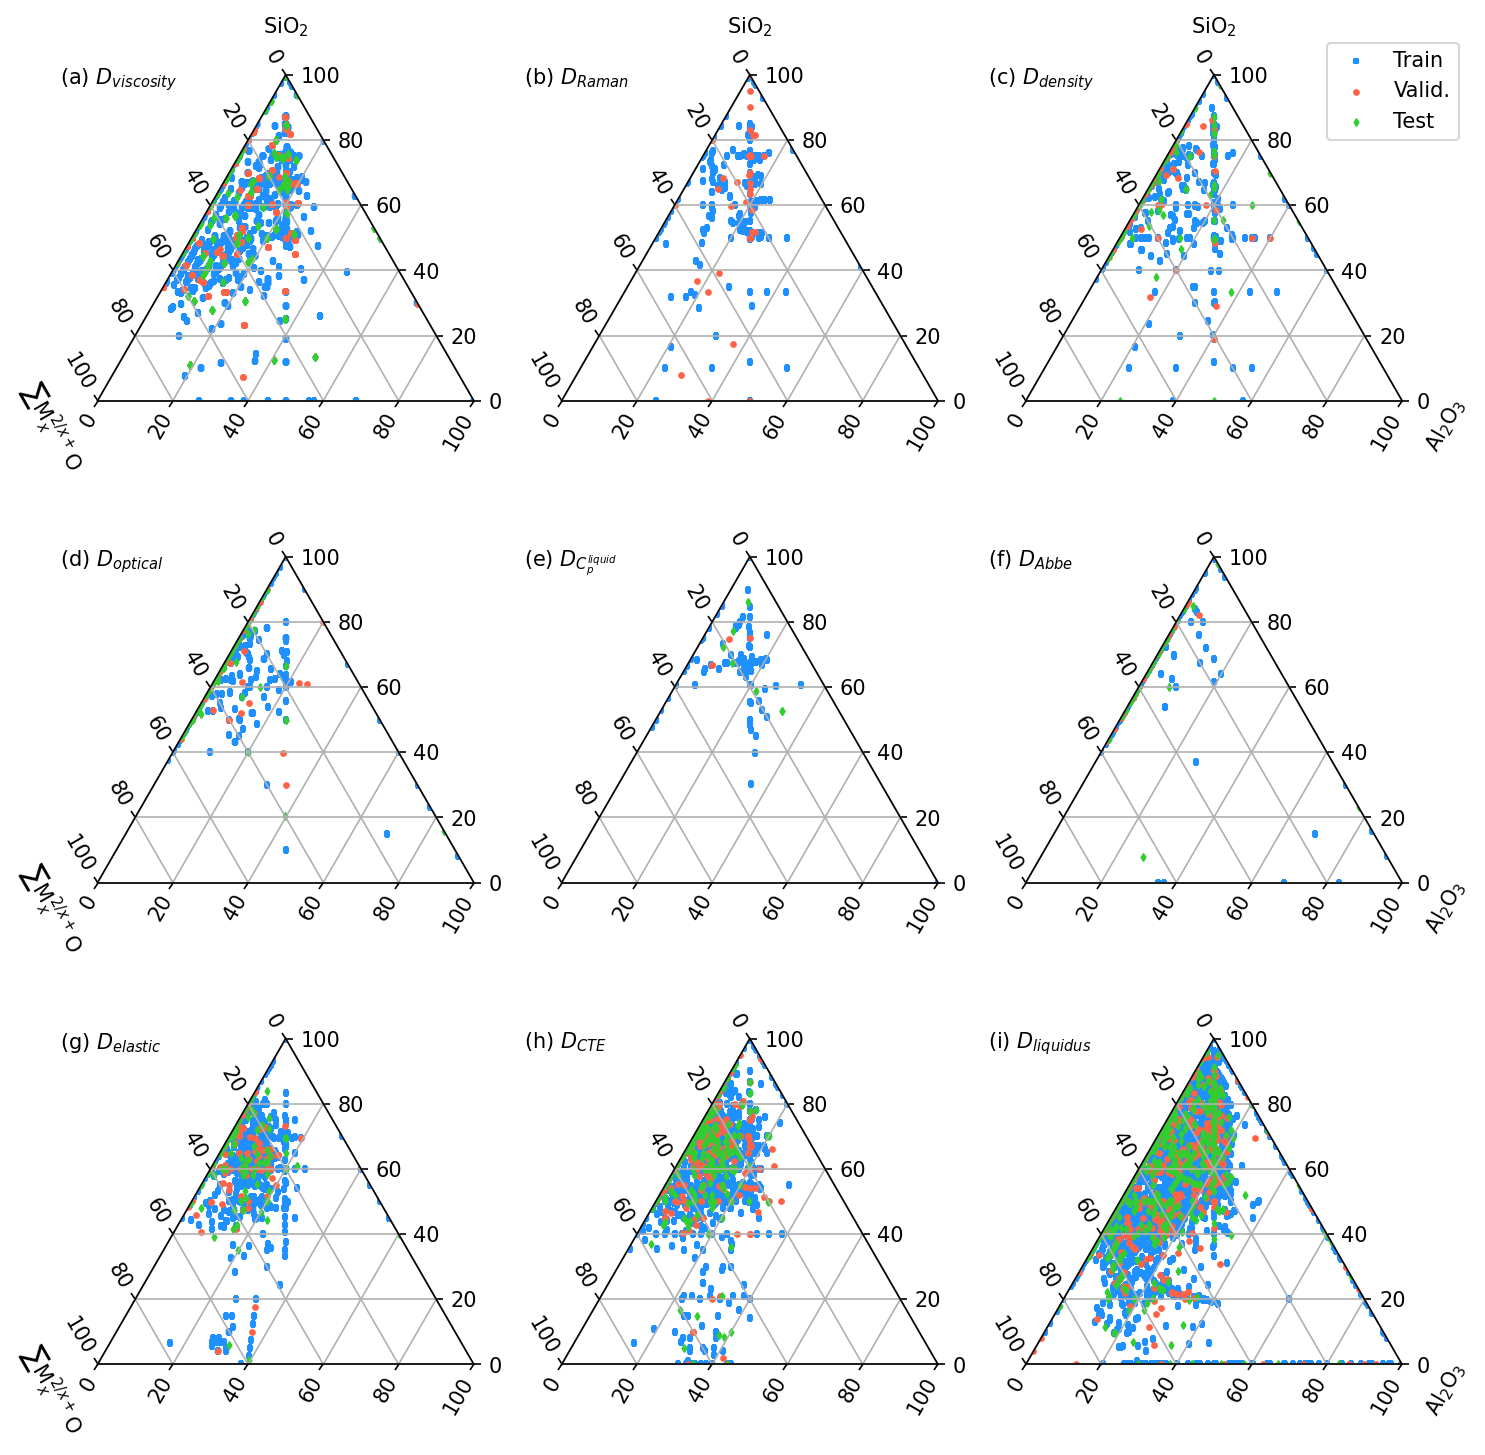

In [3]:
marker_size = 5
plt.figure(figsize=(10,10),dpi=150)

colors = ['dodgerblue', 'tomato', 'limegreen']
ax1 = plt.subplot(3,3,1,projection='ternary',ternary_scale=100)
ax2 = plt.subplot(3,3,2,projection='ternary',ternary_scale=100)
ax3 = plt.subplot(3,3,3,projection='ternary',ternary_scale=100)
ax4 = plt.subplot(3,3,4,projection='ternary',ternary_scale=100)
ax5 = plt.subplot(3,3,5,projection='ternary',ternary_scale=100)
ax6 = plt.subplot(3,3,6,projection='ternary',ternary_scale=100)
ax7 = plt.subplot(3,3,7,projection='ternary',ternary_scale=100)
ax8 = plt.subplot(3,3,8,projection='ternary',ternary_scale=100)
ax9 = plt.subplot(3,3,9,projection='ternary',ternary_scale=100)

# The data
ax1.scatter(ds.x_visco_train.detach().numpy()[:,0], ds.x_visco_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Train data subset")
ax1.scatter(ds.x_visco_valid.detach().numpy()[:,0], ds.x_visco_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation data subset")
ax1.scatter(ds.x_visco_test.detach().numpy()[:,0], ds.x_visco_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing data subset")

ax2.scatter(ds.x_raman_train.detach().numpy()[:,0], ds.x_raman_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_raman_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Ent.")
ax2.scatter(ds.x_raman_valid.detach().numpy()[:,0], ds.x_raman_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_raman_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")

ax3.scatter(ds.x_density_train.detach().numpy()[:,0], ds.x_density_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Train")
ax3.scatter(ds.x_density_valid.detach().numpy()[:,0], ds.x_density_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")
ax3.scatter(ds.x_density_test.detach().numpy()[:,0], ds.x_density_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Test")

ax4.scatter(ds.x_ri_train.detach().numpy()[:,0], ds.x_ri_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Ent.")
ax4.scatter(ds.x_ri_valid.detach().numpy()[:,0], ds.x_ri_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")
ax4.scatter(ds.x_ri_test.detach().numpy()[:,0], ds.x_ri_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Test")

ax5.scatter(ds.x_cpl_train.detach().numpy()[:,0], ds.x_cpl_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax5.scatter(ds.x_cpl_valid.detach().numpy()[:,0], ds.x_cpl_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax5.scatter(ds.x_cpl_test.detach().numpy()[:,0], ds.x_cpl_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax6.scatter(ds.x_abbe_train.detach().numpy()[:,0], ds.x_abbe_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax6.scatter(ds.x_abbe_valid.detach().numpy()[:,0], ds.x_abbe_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax6.scatter(ds.x_abbe_test.detach().numpy()[:,0], ds.x_abbe_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax7.scatter(ds.x_elastic_train.detach().numpy()[:,0], ds.x_elastic_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax7.scatter(ds.x_elastic_valid.detach().numpy()[:,0], ds.x_elastic_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax7.scatter(ds.x_elastic_test.detach().numpy()[:,0], ds.x_elastic_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax8.scatter(ds.x_cte_train.detach().numpy()[:,0], ds.x_cte_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax8.scatter(ds.x_cte_valid.detach().numpy()[:,0], ds.x_cte_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax8.scatter(ds.x_cte_test.detach().numpy()[:,0], ds.x_cte_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax9.scatter(ds.x_liquidus_train.detach().numpy()[:,0], ds.x_liquidus_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax9.scatter(ds.x_liquidus_valid.detach().numpy()[:,0], ds.x_liquidus_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax9.scatter(ds.x_liquidus_test.detach().numpy()[:,0], ds.x_liquidus_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

# add grid
for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    i.grid(axis='t')
    i.grid(axis='l')
    i.grid(axis='r')

# label axis
for i in [ax1, ax2, ax3]:
    i.set_tlabel('SiO$_2$')

for i in [ax1, ax4, ax7]:
    i.set_llabel('$\sum$M$^{2/x+}_{x}$O')

for i in [ax3, ax6, ax9]:
    i.set_rlabel('Al$_2$O$_3$')

# annotation of the subplots
ax1.annotate("(a) $D_{viscosity}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax2.annotate("(b) $D_{Raman}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax3.annotate("(c) $D_{density}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax4.annotate("(d) $D_{optical}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax5.annotate("(e) $D_{C_{p}^{liquid}}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax6.annotate("(f) $D_{Abbe}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax7.annotate("(g) $D_{elastic}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax8.annotate("(h) $D_{CTE}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax9.annotate("(i) $D_{liquidus}$",xy=(-0.1,0.97),xycoords="axes fraction")

# output things
plt.tight_layout()
ax3.legend(loc=(0.8,0.8),fontsize=10)

plt.savefig("./figures/manuscript/Figure1.pdf")

# Figure 2

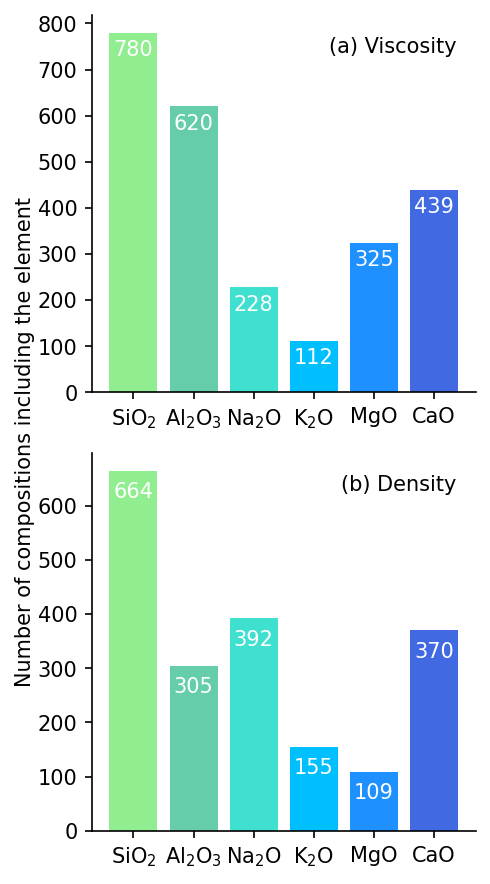

In [4]:
###
# # Quantity of each chemical component in the datasets of viscosity and density
###

# get full chemical sets
x_visco = torch.cat((ds.x_visco_train, ds.x_visco_valid, ds.x_visco_test)).unique(dim=0)
x_density = torch.cat((ds.x_density_train, ds.x_density_valid, ds.x_density_test)).unique(dim=0)

# lists to count things
nb_visco = []
nb_density = []

# loop for counting
for i in range(6):
    nb_visco.append(len(np.where(x_visco[:,i]!=0)[0]))
    nb_density.append(len(np.where(x_density[:,i]!=0)[0]))
    
#
# make figure
#
fig = plt.figure(figsize=(3.22,6), dpi=150)

colors=['lightgreen', 'mediumaquamarine', 'turquoise', 'deepskyblue', 'dodgerblue', 'royalblue']

#
# first subplot
#
ax = plt.subplot(211)
plt.bar(range(0,6),nb_visco, tick_label=['SiO$_2$', 'Al$_2$O$_3$', 'Na$_2$O', 'K$_2$O', 'MgO', 'CaO'],color=colors)
plt.annotate("(a) Viscosity",xy=(0.95,0.9),xycoords="axes fraction",ha="right")
for count,i in enumerate(nb_visco):
    plt.annotate(str(i),xy=(count,i-50),xycoords="data",color='w', ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#
# second subplot
#
ax = plt.subplot(212)
plt.bar(range(0,6),nb_density, tick_label=['SiO$_2$', 'Al$_2$O$_3$', 'Na$_2$O', 'K$_2$O', 'MgO', 'CaO'],color=colors)
plt.annotate("(b) Density",xy=(0.95,0.9),xycoords="axes fraction",ha="right")
for count,i in enumerate(nb_density):
    plt.annotate(str(i),xy=(count,i-50),xycoords="data",color='w', ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.text(0.0, 0.5, "Number of compositions including the element", va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure2.pdf")


# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [5]:
RMSE_ag_tot, RMSE_ag_low, RMSE_ag_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='ag', boundary=7)
RMSE_cg_tot, RMSE_cg_low, RMSE_cg_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='cg', boundary=7)
RMSE_tvf_tot, RMSE_tvf_low, RMSE_tvf_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='tvf', boundary=7)
RMSE_am_tot, RMSE_am_low, RMSE_am_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='am', boundary=7)
RMSE_myega_tot, RMSE_myega_low, RMSE_myega_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='myega', boundary=7)



Using the equation from Adam-Gibbs:
    RMSE on the full range (0-15 log Pa s): train 0.24, valid 0.32, test 0.38
    RMSE on the -inf - 7.0 log Pa s range: train 0.19, valid 0.24, test 0.25
    RMSE on the 7.0 - +inf log Pa s range: train 0.31, valid 0.40, test 0.57

Using the equation from Free Volume:
    RMSE on the full range (0-15 log Pa s): train 0.24, valid 0.29, test 0.36
    RMSE on the -inf - 7.0 log Pa s range: train 0.21, valid 0.22, test 0.26
    RMSE on the 7.0 - +inf log Pa s range: train 0.30, valid 0.36, test 0.50

Using the equation from Vogel Fulcher Tamman:
    RMSE on the full range (0-15 log Pa s): train 0.28, valid 0.30, test 0.39
    RMSE on the -inf - 7.0 log Pa s range: train 0.27, valid 0.26, test 0.33
    RMSE on the 7.0 - +inf log Pa s range: train 0.31, valid 0.36, test 0.50

Using the equation from Avramov Milchev:
    RMSE on the full range (0-15 log Pa s): train 0.22, valid 0.27, test 0.34
    RMSE on the -inf - 7.0 log Pa s range: train 0.17, valid 0.

In [6]:
# Now we calculate on density and refractive index
ese_density_train, mae_density_train = utils.residual_error_calc(ds.y_density_train, neuralmodel.predict("density_glass",ds.x_density_train).mean(axis=1))
ese_density_valid, mae_density_valid = utils.residual_error_calc(ds.y_density_valid, neuralmodel.predict("density_glass",ds.x_density_valid).mean(axis=1))
ese_density_test, mae_density_test = utils.residual_error_calc(ds.y_density_test, neuralmodel.predict("density_glass",ds.x_density_test).mean(axis=1))

ese_ri_train, mae_ri_train = utils.residual_error_calc(ds.y_ri_train, neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1))
ese_ri_valid, mae_ri_valid = utils.residual_error_calc(ds.y_ri_valid, neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1))
ese_ri_test, mae_ri_test = utils.residual_error_calc(ds.y_ri_test, neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1))

ese_abbe_train, mae_abbe_train = utils.residual_error_calc(ds.y_abbe_train, neuralmodel.predict("abbe",ds.x_abbe_train).mean(axis=1))
ese_abbe_valid, mae_abbe_valid = utils.residual_error_calc(ds.y_abbe_valid, neuralmodel.predict("abbe",ds.x_abbe_valid).mean(axis=1))
ese_abbe_test, mae_abbe_test = utils.residual_error_calc(ds.y_abbe_test, neuralmodel.predict("abbe",ds.x_abbe_test).mean(axis=1))

ese_liquidus_train, mae_liquidus_train = utils.residual_error_calc(ds.y_liquidus_train, neuralmodel.predict("liquidus",ds.x_liquidus_train).mean(axis=1))
ese_liquidus_valid, mae_liquidus_valid = utils.residual_error_calc(ds.y_liquidus_valid, neuralmodel.predict("liquidus",ds.x_liquidus_valid).mean(axis=1))
ese_liquidus_test, mae_liquidus_test = utils.residual_error_calc(ds.y_liquidus_test, neuralmodel.predict("liquidus",ds.x_liquidus_test).mean(axis=1))

ese_elastic_train, mae_elastic_train = utils.residual_error_calc(ds.y_elastic_train, neuralmodel.predict("elastic_modulus",ds.x_elastic_train).mean(axis=1))
ese_elastic_valid, mae_elastic_valid = utils.residual_error_calc(ds.y_elastic_valid, neuralmodel.predict("elastic_modulus",ds.x_elastic_valid).mean(axis=1))
ese_elastic_test, mae_elastic_test = utils.residual_error_calc(ds.y_elastic_test, neuralmodel.predict("elastic_modulus",ds.x_elastic_test).mean(axis=1))

ese_cte_train, mae_cte_train = utils.residual_error_calc(ds.y_cte_train, neuralmodel.predict("cte",ds.x_cte_train).mean(axis=1))
ese_cte_valid, mae_cte_valid = utils.residual_error_calc(ds.y_cte_valid, neuralmodel.predict("cte",ds.x_cte_valid).mean(axis=1))
ese_cte_test, mae_cte_test = utils.residual_error_calc(ds.y_cte_test, neuralmodel.predict("cte",ds.x_cte_test).mean(axis=1))

ese_tg_train, mae_tg_train = utils.residual_error_calc(ds.y_tg_train.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1))
ese_tg_valid, mae_tg_valid = utils.residual_error_calc(ds.y_tg_valid.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1))
ese_tg_test, mae_tg_test = utils.residual_error_calc(ds.y_tg_test.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1))

ese_entro_train, mae_entro_train = utils.residual_error_calc(ds.y_entro_train.cpu().detach().numpy(),
                                                             neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1))
ese_entro_valid, mae_entro_valid = utils.residual_error_calc(ds.y_entro_valid.cpu().detach().numpy(),
                                                             neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1))
ese_entro_test, mae_entro_test = utils.residual_error_calc(ds.y_entro_test.cpu().detach().numpy(),
                                                           neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1))

print('RMSE density train after training {0:.3f}'.format(ese_density_train))
print('RMSE density valid after training {0:.2f}'.format(ese_density_valid))
print('RMSE density test after training {0:.2f}'.format(ese_density_test))
print('')

print('RMSE refractive train loss after training {0:.3f}'.format(ese_ri_train))
print('RMSE refractive valid loss after training {0:.3f}'.format(ese_ri_valid))
print('RMSE refractive test loss after training {0:.3f}'.format(ese_ri_test))
print('')

print('RMSE liquidus train after training {0:.0f}'.format(ese_liquidus_train))
print('RMSE liquidus valid after training {0:.0f}'.format(ese_liquidus_valid))
print('RMSE liquidus test after training {0:.0f}'.format(ese_liquidus_test))
print('')

print('RMSE Abbe number train after training {0:.1f}'.format(ese_abbe_train))
print('RMSE Abbe number valid after training {0:.1f}'.format(ese_abbe_valid))
print('RMSE Abbe number test after training {0:.1f}'.format(ese_abbe_test))
print('')

print('RMSE Elastic Modulus train after training {0:.1f}'.format(ese_elastic_train))
print('RMSE Elastic Modulus valid after training {0:.1f}'.format(ese_elastic_valid))
print('RMSE Elastic Modulus test after training {0:.1f}'.format(ese_elastic_test))
print('')

print('RMSE CTE train after training {0:.1f}'.format(ese_cte_train))
print('RMSE CTE valid after training {0:.1f}'.format(ese_cte_valid))
print('RMSE CTE test after training {0:.1f}'.format(ese_cte_test))
print('')

print('RMSE Tg train after training {0:.1f}'.format(ese_tg_train))
print('RMSE Tg valid after training {0:.1f}'.format(ese_tg_valid))
print('RMSE Tg test after training {0:.1f}'.format(ese_tg_test))
print('')

print('RMSE Sc(Tg) train after training {0:.1f}'.format(ese_entro_train))
print('RMSE Sc(Tg) valid after training {0:.1f}'.format(ese_entro_valid))
print('RMSE Sc(Tg) test after training {0:.1f}'.format(ese_entro_test))
print('')


RMSE density train after training 0.012
RMSE density valid after training 0.01
RMSE density test after training 0.02

RMSE refractive train loss after training 0.003
RMSE refractive valid loss after training 0.004
RMSE refractive test loss after training 0.005

RMSE liquidus train after training 54
RMSE liquidus valid after training 59
RMSE liquidus test after training 55

RMSE Abbe number train after training 1.1
RMSE Abbe number valid after training 0.4
RMSE Abbe number test after training 3.8

RMSE Elastic Modulus train after training 4.4
RMSE Elastic Modulus valid after training 8.5
RMSE Elastic Modulus test after training 5.9

RMSE CTE train after training 1.0
RMSE CTE valid after training 0.9
RMSE CTE test after training 1.1

RMSE Tg train after training 11.5
RMSE Tg valid after training 13.2
RMSE Tg test after training 15.6

RMSE Sc(Tg) train after training 0.7
RMSE Sc(Tg) valid after training 1.6
RMSE Sc(Tg) test after training 0.9



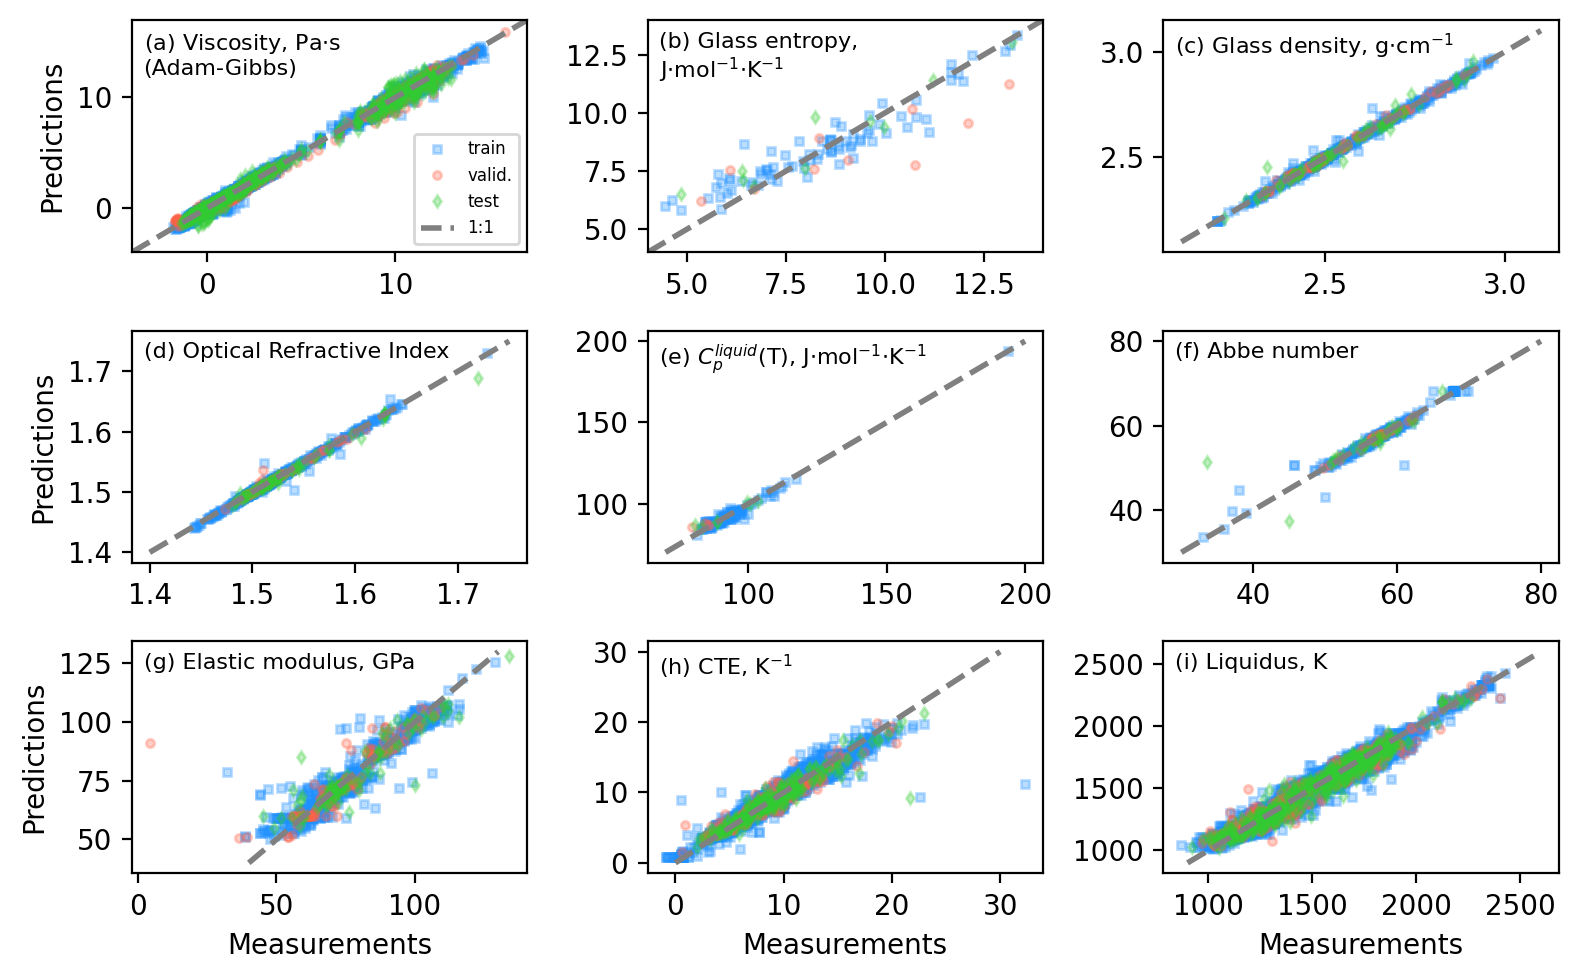

In [7]:
plt.figure(figsize=(8,5),dpi=200)

c1 = 'dodgerblue'
c2 = 'tomato'
c3 = 'limegreen'
alpha_=0.3
ms = 3

#
# Glass transition temperature
#
tx2 = plt.subplot(331)
tx2.plot(ds.y_visco_train.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_train, ds.T_visco_train).mean(axis=1),
         "s",linestyle="none",color=c1,markersize=ms,label="train",alpha=alpha_)
tx2.plot(ds.y_visco_valid.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_valid, ds.T_visco_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="valid.",alpha=alpha_)
tx2.plot(ds.y_visco_test.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_test, ds.T_visco_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

plt.xlim(-4,17)
plt.ylim(-4,17)

#
# Configurational entropy
#
tx3 = plt.subplot(332)
tx3.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="ent.",alpha=alpha_)
tx3.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="valid",alpha=alpha_)
tx3.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

plt.xlim(4,14)
plt.ylim(4,14)

#
# Density
#
tx4=plt.subplot(333)
tx4.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="ent.",alpha=alpha_)
tx4.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="valid.",alpha=alpha_)
tx4.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
# Refractive index
#
tx5 = plt.subplot(334)

l1 =tx5.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="entraînement",alpha=alpha_)
l2 = tx5.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="validation",alpha=alpha_)
l3 =tx5.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
# LIQUID HEAT CAPACITY
#
tx6 = plt.subplot(335)

tx6.plot(ds.y_cpl_train.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_train, T=ds.T_cpl_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="entraînement",alpha=alpha_)
tx6.plot(ds.y_cpl_valid.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_valid, T=ds.T_cpl_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="validation",alpha=alpha_)
tx6.plot(ds.y_cpl_test.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_test, T=ds.T_cpl_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
#ABBE NUMBER
#
tx7 = plt.subplot(336)
tx7.plot(ds.y_abbe_train.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx7.plot(ds.y_abbe_valid.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx7.plot(ds.y_abbe_test.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# YOUNG MODULUS
#
tx8 = plt.subplot(337)
tx8.plot(ds.y_elastic_train.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx8.plot(ds.y_elastic_valid.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx8.plot(ds.y_elastic_test.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# CTE
#
tx9 = plt.subplot(338)
tx9.plot(ds.y_cte_train.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx9.plot(ds.y_cte_valid.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx9.plot(ds.y_cte_test.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# LIQUIDUS TEMPERATURE
#
tx10 = plt.subplot(339)
tx10.plot(ds.y_liquidus_train.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_train).mean(axis=1),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx10.plot(ds.y_liquidus_valid.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_valid).mean(axis=1),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx10.plot(ds.y_liquidus_test.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_test).mean(axis=1),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

# plot the 1:1 lines
tx2.plot([-4,17],[-4,17],"--",color="grey",linewidth=2,label="1:1")
tx3.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")
tx4.plot([2.1,3.1],[2.1,3.1],"--",color="grey",linewidth=2,label="1:1")
tx5.plot([1.4,1.75],[1.4,1.75],"--",color="grey",linewidth=2,label="1:1")
tx6.plot([70,200],[70,200],"--",color="grey",linewidth=2,label="1:1")
tx7.plot([30,80],[30,80],"--",color="grey",linewidth=2,label="1:1")
tx8.plot([40,130],[40,130],"--",color="grey",linewidth=2,label="1:1")
tx9.plot([0,30],[0,30],"--",color="grey",linewidth=2,label="1:1")
tx10.plot([900,2600],[900,2600],"--",color="grey",linewidth=2,label="1:1")

# labelling axis
tx2.set_ylabel("Predictions")
tx5.set_ylabel("Predictions")
tx8.set_ylabel("Predictions")
tx8.set_xlabel("Measurements")
tx9.set_xlabel("Measurements")
tx10.set_xlabel("Measurements")

# annotate the plots
subplot_titles=["(a) Viscosity, Pa$\cdot$s\n(Adam-Gibbs)",
                "(b) Glass entropy, \nJ$\cdot$mol$^{-1}$$\cdot$K$^{-1}$",
                "(c) Glass density, g$\cdot$cm$^{-1}$",
                "(d) Optical Refractive Index",
                "(e) $C_p^{liquid}$(T), J$\cdot$mol$^{-1}$$\cdot$K$^{-1}$",
                "(f) Abbe number",
                "(g) Elastic modulus, GPa",
                "(h) CTE, K$^{-1}$",
                "(i) Liquidus, K",
               ]
subplots = [tx2, tx3, tx4, tx5, tx6, tx7, tx8, tx9, tx10]
for i in range(9):
    subplots[i].annotate(subplot_titles[i],xy=(0.03,0.95),xycoords="axes fraction", fontsize=8, va="top")

# legend
tx2.legend(loc=4, fontsize=6)
    
plt.tight_layout()

plt.savefig("./figures/manuscript/Figure3.pdf")


# Raman spectra

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

We generate a figure comparing predictions and observations.

Least-Absolute Deviations are also calculated, as well as the R_Raman parameters.

Median of the Relative Least Squared Error on Train Raman dataset is 19.89%
Median of the Relative Least Squared Error on Valid Raman dataset is 26.65%
RMSE of R Raman train: 17.765160673566207
RMSE of R Raman valid: 26.060632200783424


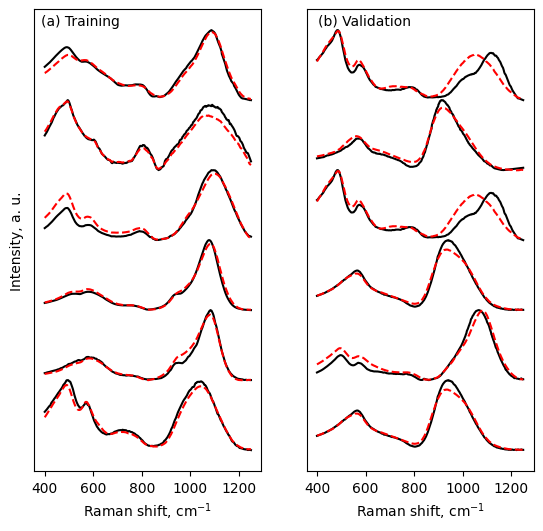

In [8]:
#
# Predictions for Raman spectra
#

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

#
# Error on Raman data
#
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.sqrt((raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())**2)/raman_train_predictions[i,:])

Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.sqrt((raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())**2)/raman_valid_predictions[i,:])

print("Median of the Relative Least Squared Error on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))
print("Median of the Relative Least Squared Error on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))

#
# Calculating the R_Raman
#

Rr_train = imelt.R_Raman(x_raman_shift, ds.y_raman_train.detach().numpy())
Rr_valid = imelt.R_Raman(x_raman_shift, ds.y_raman_valid.detach().numpy())

Rr_train_pred = imelt.R_Raman(x_raman_shift, raman_train_predictions)
Rr_valid_pred = imelt.R_Raman(x_raman_shift, raman_valid_predictions)

print("RMSE of R Raman train: {}".format(100*np.mean(np.sqrt((Rr_train - Rr_train_pred)**2)/Rr_train)))
print("RMSE of R Raman valid: {}".format(100*np.mean(np.sqrt((Rr_valid - Rr_valid_pred)**2)/Rr_valid)))

#
# Figure for the Raman spectra
#
plt.figure(figsize=(6.44,6))

plt.subplot(1,2,1)
plt.annotate("(a) Training",xy=(0.03,0.99),xycoords="axes fraction", va="top")
shift=0
for i in np.random.randint(0,high=ds.x_raman_train.shape[0],size=6):
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,"r--")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

plt.subplot(1,2,2)
plt.annotate("(b) Validation",xy=(0.05,0.99),xycoords="axes fraction", va="top")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in np.random.randint(0,high=ds.x_raman_valid.shape[0],size=6):
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,"r--")
    shift += 1.

plt.yticks([])
    
plt.xlabel("Raman shift, cm$^{-1}$")
plt.savefig("./figures/manuscript/Figure4.pdf")

# Evaluate accuracy of Raman predictions

# Fragility versus $C_p^{conf}/S^{conf}(T_g)$

A linear relationship should be visible according to the works of Webb (2008) or Russell and Giordano (2017)

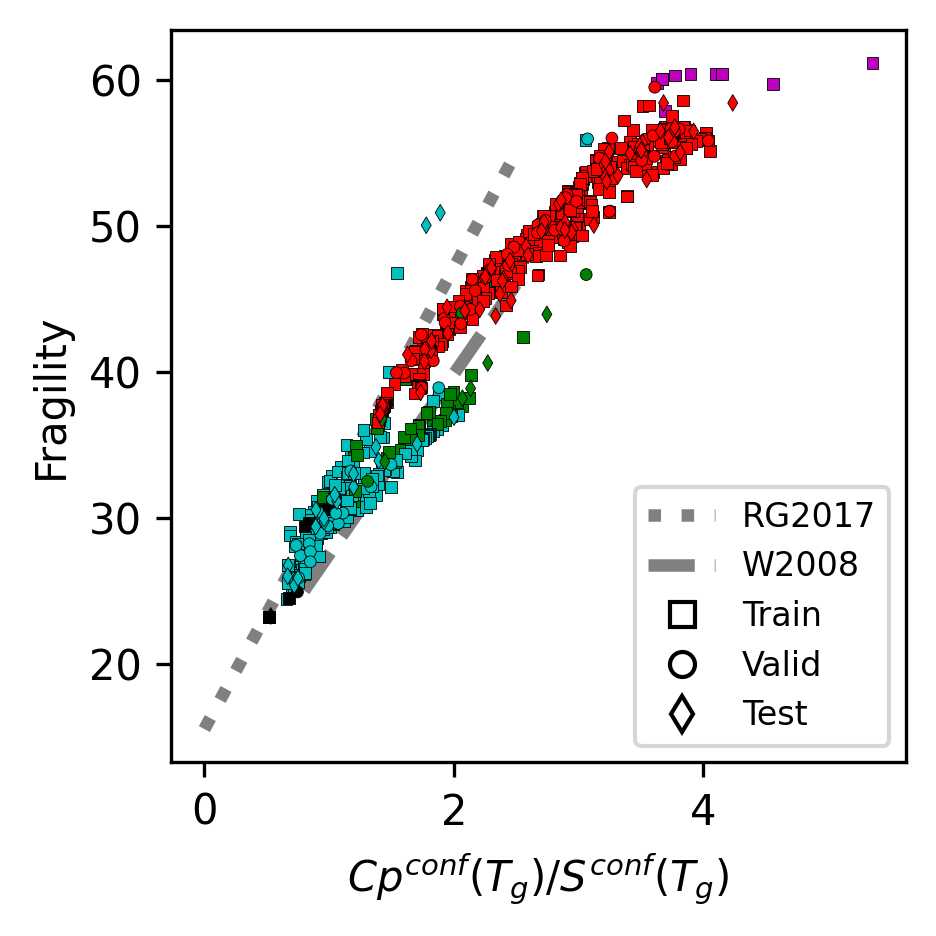

In [9]:
def color_data(chemical_set):
    colors = np.empty(len(chemical_set), dtype="str") # an array to contain my colors
    
    #colors[:] = "green"
    
    # sio2-al2o3
    colors[(chemical_set[:,2:6] == 0).all(axis=1)] = "b" 
    
    # all mixed
    colors[(chemical_set[:,2:4] >= 0).any(axis=1) &
           (chemical_set[:,4:6] >= 0).any(axis=1)
          ] = "green"
    
    # calc-alkali
    colors[(chemical_set[:,2:4] == 0).all(axis=1) &
           (chemical_set[:,4:6] >= 0).any(axis=1)
          ] = "r" 
    
    # alkali
    colors[(chemical_set[:,2:4] >= 0).any(axis=1) &
           (chemical_set[:,4:6] == 0).all(axis=1)
          ] = "cyan"
    
    # aluminate
    colors[chemical_set[:,0] == 0] = "m" 
    
    # silica rich = black
    colors[chemical_set[:,0] > 0.95] = "k"
    return colors

def data_m_vs_CpSc(dataset, ax, label, marker = "s"):
    ds_in = torch.unique(dataset, dim=0)
    Cpconf = (neuralmodel.predict("ap_calc",ds_in).mean(axis=1) + 
          neuralmodel.predict("bCpl",ds_in).mean(axis=1)*
          neuralmodel.predict("tg",ds_in).mean(axis=1))
    Cp_S = Cpconf/neuralmodel.predict("sctg",ds_in).mean(axis=1)
    fragil = neuralmodel.predict("fragility",ds_in).mean(axis=1)
    
    ax.scatter(Cp_S, fragil,
            marker=marker,edgecolors="k",linewidths=0.2,
            c=color_data(ds_in),
            s=8, alpha=1, label=label)
    
    return ax


plt.figure(figsize=(3.22,3.22),dpi=300)
ax = plt.subplot()

# plotting published trends
ax.plot([0., 2.5], [15.51, 55], ":", color="grey", linewidth=3, label="RG2017", alpha=1., zorder=-1)
ax.plot([0.8, 2.5], [25., 46], "--", color="grey", linewidth=3, label="W2008", alpha=1., zorder=-1)

ax.plot([],[], "ks", mfc="white", label="Train")
ax.plot([],[], "ko", mfc="white", label="Valid")
ax.plot([],[], "kd", mfc="white", label="Test")
plt.legend(fontsize = 8, loc=4)

# plotting i-Melt predictions
ax = data_m_vs_CpSc(ds.x_visco_train, ax, "Train", marker="s")
ax = data_m_vs_CpSc(ds.x_visco_valid, ax, "Valid", marker="o")
ax = data_m_vs_CpSc(ds.x_visco_test,  ax, "Test", marker="d")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure5.pdf")


# Confidence interval analysis

First we calculate how much data fall within the 95% confidence intervals calculated using MC dropout. Ideally, 95% of the data should fall in the provided confidence intervals. We use conformal prediction to scale the MC dropout c.i.s

Second, we show how we can detect extrapolation with MC dropout error bars.

In [10]:
methods_ = ["Density","Viscosity","Optical refractive index","Liquidus", "Heat capacity", "Abbe","Elastic","CTE"]
df_errors = pd.DataFrame(methods_, columns=["method"])
df_errors["MC dropout"]=0.0
df_errors["with C.P."]=0.0
n_sample=200


x_cal= (ds.x_density_valid, ds.x_visco_valid, ds.x_ri_valid, ds.x_liquidus_valid,
        ds.x_cpl_valid, ds.x_abbe_valid, ds.x_elastic_valid, ds.x_cte_valid)
y_cal= (ds.y_density_valid, ds.y_visco_valid, ds.y_ri_valid, ds.y_liquidus_valid,
        ds.y_cpl_valid, ds.y_abbe_valid, ds.y_elastic_valid, ds.y_cte_valid)

x_test= (ds.x_density_test, ds.x_visco_test, ds.x_ri_test, ds.x_liquidus_test,
        ds.x_cpl_test, ds.x_abbe_test, ds.x_elastic_test, ds.x_cte_test)
y_test= (ds.y_density_test, ds.y_visco_test, ds.y_ri_test, ds.y_liquidus_test,
        ds.y_cpl_test, ds.y_abbe_test, ds.y_elastic_test, ds.y_cte_test)

methods = ("density_glass","ag","sellmeier","liquidus","cpl","abbe","elastic_modulus","cte")

for i,names in enumerate(methods):
    if names == "ag":
        T_cal=ds.T_visco_valid
        T_test=ds.T_visco_test
    elif names == "cpl":
        T_cal=ds.T_cpl_valid
        T_test=ds.T_cpl_test
    else:
        T_cal = []
        T_test = []
    if names == "sellmeier":
        lbd_cal = ds.lbd_ri_valid
        lbd_test = ds.lbd_ri_test
    else:
        lbd_cal=[]
        lbd_test=[]
    
    y_preds_cal = neuralmodel.predict(names,x_cal[i],T=T_cal,lbd=lbd_cal,sampling=True, n_sample=n_sample)
    
    y_preds_test = neuralmodel.predict(names,x_test[i],T=T_test,lbd=lbd_test,sampling=True, n_sample=n_sample)
    
    df_errors.loc[i,"MC dropout"], _, _ =utils.evaluate_accuracy(y_test[i].detach().numpy(), 
                                                                 samples=y_preds_test)

    # correction of confidence intervals with Conformal Regression from aws fortuna
    test_cred_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=np.quantile(y_preds_cal,0.025, axis=1),
    val_upper_bounds=np.quantile(y_preds_cal,0.975, axis=1),
    test_lower_bounds=np.quantile(y_preds_test,0.025, axis=1),
    test_upper_bounds=np.quantile(y_preds_test,0.975, axis=1),
    val_targets=y_cal[i].detach().numpy(),
    error=0.05
    )
    
    df_errors.loc[i,"with C.P."], _, _ =utils.evaluate_accuracy(y_test[i].detach().numpy(),
                                                                ci_lower=test_cred_intervals[:,0],
                                                                ci_upper=test_cred_intervals[:,1])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
df_errors

,method,MC dropout,with C.P.
0,Density,0.869565,0.884058
1,Viscosity,0.937700,0.958466
2,Optical refractive index,0.936508,0.936508
3,Liquidus,0.886555,0.964286
4,Heat capacity,0.571429,1.000000
5,Abbe,0.851852,0.814815
6,Elastic,0.757282,0.941748
7,CTE,0.857708,0.980237


# Figure 6

### Na2O-SiO2 trend in density and Tg

In [12]:
def trend(compo_1, compo_2, nb_points=100):
    """provide a linear compositional trend between compo_1 and compo_2"""

    compo_1 = np.array(compo_1).reshape(1,6)
    compo_2 = np.array(compo_2).reshape(1,6)  
    # convert to mol
    pcm = pd.DataFrame(np.vstack((compo_1,compo_2)), columns = ["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])
    compo_mol = pcm.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"]].values

    # mixing both : we go from compo_1 to compo_2
    x_mix = np.linspace(0,1,nb_points).reshape(-1,1)
    compo_trend = x_mix*compo_mol[1,:] + (1-x_mix)*compo_mol[0,:]

    compo_trend = utils.descriptors(pd.DataFrame(compo_trend,
                                          columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values
    
    return compo_trend

sio2_na2o_compo = trend([1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.01, 0.0,.99, 0.0, 0.0, 0.0])

# get samples for density
samples = neuralmodel.predict("density_glass",sio2_na2o_compo,
                    sampling=True, n_sample=200)

d_cal = neuralmodel.predict("density_glass",ds.x_density_valid,
                    sampling=True, n_sample=200)
d_y_cal = ds.y_density_valid

# get samples for Tg
samples_tg = neuralmodel.predict("tg",sio2_na2o_compo,
                    sampling=True, n_sample=200)

tg_cal = neuralmodel.predict("tg",ds.x_tg_valid,
                    sampling=True, n_sample=200)
tg_y_cal = ds.y_tg_valid


In [13]:
# Get 2.5, median and 97.5 values
nn_lb, nn_median, nn_hb = np.quantile(samples,[0.025,0.5,0.975],axis=1)
tg_nn_lb, tg_nn_median, tg_nn_hb = np.quantile(samples_tg,[0.025,0.5,0.975],axis=1)

# correction of c.i. with conformal predictor
d_cred_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=np.quantile(d_cal,0.025, axis=1),
    val_upper_bounds=np.quantile(d_cal,0.975, axis=1),
    test_lower_bounds=np.quantile(samples,0.025, axis=1),
    test_upper_bounds=np.quantile(samples,0.975, axis=1),
    val_targets=d_y_cal.detach().numpy(),
    error=0.05
    )

# correction of c.i. with conformal predictor
tg_cred_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=np.quantile(tg_cal,0.025, axis=1),
    val_upper_bounds=np.quantile(tg_cal,0.975, axis=1),
    test_lower_bounds=np.quantile(samples_tg,0.025, axis=1),
    test_upper_bounds=np.quantile(samples_tg,0.975, axis=1),
    val_targets=tg_y_cal.detach().numpy(),
    error=0.05
    )

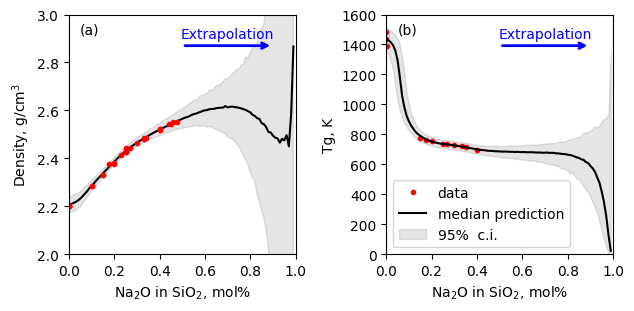

In [15]:
#
# Loading density data for subsequent figures
#
data_density = pd.read_excel("./data/Database.xlsx", sheet_name="DENSITY")
data_tg = pd.read_excel("./data/Database.xlsx", sheet_name="VISCO")
data_tg = data_tg[data_tg.tg != 0].copy()
data_tg.drop_duplicates(subset ="Name",keep = "first", inplace = True)

plt.figure(figsize=(6.44,3.22))
ax1 = plt.subplot(1,2,1)

# prediction from i-Melt
plt.plot(sio2_na2o_compo[:,2], nn_median, "k-", label="median prediction")
plt.fill_between(sio2_na2o_compo[:,2], 
                 d_cred_intervals[:,0],
                 d_cred_intervals[:,1],
                 alpha=0.1, color='k'
                )


# data
plt.plot(data_density.na2o[(data_density.al2o3==0)&
                            (data_density.k2o==0)&
                            (data_density.mgo==0)&
                            (data_density.cao==0)
                           ]/100, 
         data_density.d[(data_density.al2o3==0)&
                            (data_density.k2o==0)&
                            (data_density.mgo==0)&
                            (data_density.cao==0)
                           ],
         "r.", label="data"
        )
plt.xlim(0,1.0)
plt.ylim(2,3)

plt.annotate("(a)", xy=(0.05,0.92), xycoords="axes fraction")

plt.xlabel("Na$_2$O in SiO$_2$, mol%")
plt.ylabel("Density, g/cm$^3$")

ax2 = plt.subplot(1,2,2)
plt.plot(data_tg.na2o[(data_tg.al2o3==0)&
                        (data_tg.k2o==0)&
                        (data_tg.mgo==0)&
                        (data_tg.cao==0)
                        ]/100, 
         data_tg.tg[(data_tg.al2o3==0)&
                        (data_tg.k2o==0)&
                        (data_tg.mgo==0)&
                        (data_tg.cao==0)
                        ],
         "r.", label="data"
        )

# i-Melt prediction of Tg
plt.plot(sio2_na2o_compo[:,2], tg_nn_median,"k-", label="median prediction")
# draw 95% confidence intervals
plt.fill_between(sio2_na2o_compo[:,2], 
                 tg_cred_intervals[:,0],
                 tg_cred_intervals[:,1],
                 alpha=0.1, color='k', label="95%  c.i."
                )


plt.xlim(0,1.0)
plt.ylim(0,1600)


plt.annotate("(b)", xy=(0.05,0.92), xycoords="axes fraction")
plt.xlabel("Na$_2$O in SiO$_2$, mol%")
plt.ylabel("Tg, K")

# add indication for interpolation and extrapolation domains
ax1.annotate("", xy=(0.9, 0.87), xytext=(0.5, 0.87), xycoords="axes fraction",
            arrowprops=dict(arrowstyle="->", color="b",linewidth=2))
ax1.annotate("Extrapolation", xy=(0.7, 0.9), 
             xycoords="axes fraction", ha="center", color="b")

ax2.annotate("", xy=(0.9, 0.87), xytext=(0.5, 0.87), xycoords="axes fraction",
            arrowprops=dict(arrowstyle="->", color="b",linewidth=2))
ax2.annotate("Extrapolation", xy=(0.7, 0.9), 
             xycoords="axes fraction", ha="center", color="b")

# add legends
ax2.legend(loc=3)

plt.tight_layout()
plt.savefig("./figures/manuscript/Figure6.pdf")

# Molar volume and Cp analysis

First we calculate the quantiles of the partial molav volumes for the various oxides, calculated from the density compositional dataset.

Then we replicate the figures from the paper.

In [16]:
# read all data
df2 = pd.read_excel("./data/Database.xlsx",sheet_name="DENSITY")

# add descriptors
X_in = utils.descriptors(df2.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100)
y_in = df2.d

# predict molar volum with neuralmodel
vm_g = neuralmodel.predict("vm_glass", X_in.values).mean(axis=-1)
partial_cpl = neuralmodel.predict("partial_cpl", X_in.values)

print("Mean molar volumes are:")
for count, i in enumerate(["SiO2", "Al2O3", "Na2O", "K2O", "MgO", "CaO"]):
    print("Vm {}: {:.1f} +{:.1f} -{:.1f}".format(i, np.median(vm_g[:,count]),
                                                 np.quantile(vm_g[:,count], 0.975),
                                                np.quantile(vm_g[:,count], 0.025)))

print("Mean partial aCpl are:")
for count, i in enumerate(["SiO2", "Al2O3", "Na2O", "K2O", "MgO", "CaO"]):
    print("aCpl {}: {:.0f} ± {:.0f}".format(i, np.mean(partial_cpl[:,count].mean(axis=-1)),np.std(partial_cpl[:,count].mean(axis=-1))))

print("Mean partial bCpl are:")
for count, i in enumerate(["Al2O3", "K2O"]):
    print("bCpl {}: {:.5f} ± {:.5f}".format(i, np.mean(partial_cpl[:,count+6].mean(axis=-1)),np.std(partial_cpl[:,count+6].mean(axis=-1))))

    

Mean molar volumes are:
Vm SiO2: 25.9 +27.1 -24.4
Vm Al2O3: 38.6 +39.7 -34.4
Vm Na2O: 22.6 +30.9 -20.5
Vm K2O: 36.7 +56.9 -34.0
Vm MgO: 13.6 +16.1 -10.3
Vm CaO: 14.8 +18.0 -14.0
Mean partial aCpl are:
aCpl SiO2: 81 ± 2
aCpl Al2O3: 112 ± 7
aCpl Na2O: 99 ± 5
aCpl K2O: 71 ± 12
aCpl MgO: 82 ± 7
aCpl CaO: 90 ± 6
Mean partial bCpl are:
bCpl Al2O3: 0.02619 ± 0.00624
bCpl K2O: 0.01636 ± 0.00407


In [17]:
# Trend at 75 mol% SiO2
def trend(compo_1, compo_2, neuralmodel, nb_points=100, nb_sample = 10):

    compo_1 = np.array(compo_1).reshape(1,6)
    compo_2 = np.array(compo_2).reshape(1,6)  
    # convert to mol
    pcm = pd.DataFrame(np.vstack((compo_1,compo_2)), columns = ["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])
    compo_mol = pcm.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"]].values

    # mixing both : we go from pyrolite to MORB
    x_mix = np.linspace(0,1,nb_points).reshape(-1,1)
    mo_compo = x_mix*compo_mol[1,:] + (1-x_mix)*compo_mol[0,:]

    mo_compo = utils.descriptors(pd.DataFrame(mo_compo,
                                          columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values
    
    print(mo_compo.shape)
    
    partial_vm = neuralmodel.predict("vm_glass", mo_compo, sampling=True, n_sample=nb_sample)
    partial_cpl = neuralmodel.predict("partial_cpl", mo_compo, sampling=True, n_sample=nb_sample)
    density_glass = neuralmodel.predict("density_glass", mo_compo, sampling=True, n_sample=nb_sample)
    tg_glass = neuralmodel.predict("tg", mo_compo, sampling=True, n_sample=nb_sample)
    
    return mo_compo, partial_vm, partial_cpl, density_glass, tg_glass

# we predict a trend at 75 mol% SiO2
c_na, v_na, cpl_na, d_na, tg_na  = trend([0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
                                  [0.5, 0.3, 0.2, 0.0, 0.0, 0.0],
                        neuralmodel
                        )

c_k, v_k, cpl_k, d_k, tg_k  = trend([0.5, 0.0, 0.0, 0.5, 0.0, 0.0],
                              [0.5, 0.3, 0.0, 0.2, 0.0, 0.0],
                         neuralmodel
                        )

c_mg, v_mg, cpl_mg, d_mg, tg_mg  = trend([0.5, 0.0, 0.0, 0.0, 0.5, 0.0],
                                  [0.5, 0.3, 0.0, 0.0, 0.2, 0.0],
                         neuralmodel
                        )

c_ca, v_ca, cpl_ca, d_ca, tg_ca  = trend([0.5, 0.0, 0.0, 0.0, 0.0, 0.5],
                                  [0.5, 0.3, 0.0, 0.0, 0.0, 0.2],
                         neuralmodel
                        )



(100, 39)
(100, 39)
(100, 39)
(100, 39)


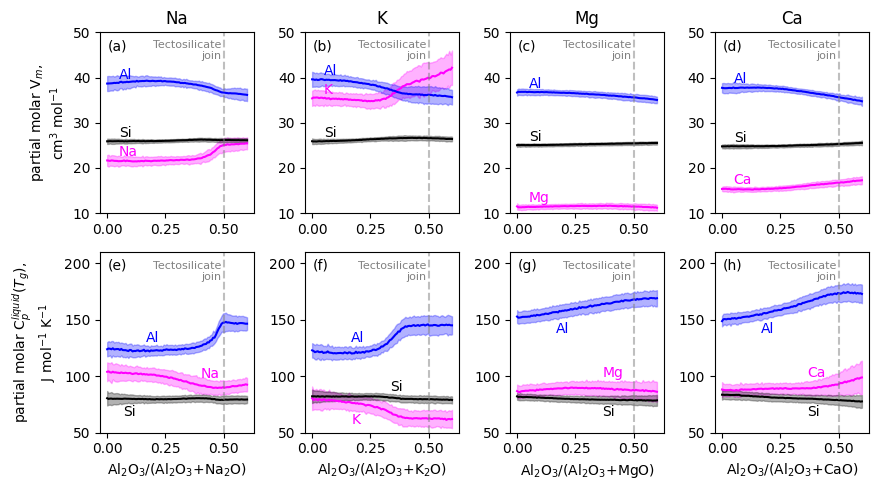

In [18]:
def subplots_Vm_Cpl(ax1, ax2, c_, v_, cpl_, tg_, cation="Na"):
    
    corresp = {"Na":2, "K":3, "Mg":4, "Ca":5}
    
    x_axis_values = c_[:,1]/(c_[:,1]+c_[:,corresp[cation]])
    
    ax1.plot(x_axis_values, v_[:,corresp[cation],:].mean(axis=-1), "-", color="magenta", alpha=1, label=cation)
    ax1.plot(x_axis_values, v_[:,1,:].mean(axis=-1),"b-", alpha=1, label="Al")
    ax1.plot(x_axis_values, v_[:,0,:].mean(axis=-1),"-", color="k", alpha=1, label="Si")
    
    ax1.fill_between(x_axis_values, 
                 v_[:,corresp[cation],:].mean(axis=-1)-2*v_[:,corresp[cation],:].std(axis=-1),
                 v_[:,corresp[cation],:].mean(axis=-1)+2*v_[:,corresp[cation],:].std(axis=-1),
                 color="magenta", alpha=0.3, label=cation)

    ax1.fill_between(x_axis_values, 
                     v_[:,1,:].mean(axis=-1)-2*v_[:,1,:].std(axis=-1),
                     v_[:,1,:].mean(axis=-1)+2*v_[:,1,:].std(axis=-1),
                     color="b", alpha=0.3, label="Al")

    ax1.fill_between(x_axis_values, 
                     v_[:,0,:].mean(axis=-1)-2*v_[:,0,:].std(axis=-1),
                     v_[:,0,:].mean(axis=-1)+2*v_[:,0,:].std(axis=-1),
                     color="k", alpha=0.3, label="Si")
    
    ax1.annotate("Si", xy=(0.05, v_[0,0,:].mean()+1), xycoords="data", color="black")
    ax1.annotate("Al", xy=(0.05, v_[0,1,:].mean()+1), xycoords="data", color="blue")
    ax1.annotate(cation, xy=(0.05, v_[0,corresp[cation],:].mean()+1), xycoords="data", color="magenta")
    
    # HEAT CAPACITY
    cpl_tg_al2o3 = cpl_[:,1,:] + cpl_[:,6,:]*tg_
    
    # plot values
    ax2.plot(x_axis_values, cpl_[:,corresp[cation],:].mean(axis=-1),"-", color="magenta", alpha=1) # sodium
    ax2.plot(x_axis_values, cpl_tg_al2o3.mean(axis=-1),"b-", alpha=1) # Al
    ax2.plot(x_axis_values, cpl_[:,0,:].mean(axis=-1),"-", color="k", alpha=1) # Si

    ax2.fill_between(x_axis_values, 
                     cpl_[:,corresp[cation],:].mean(axis=-1)-2*cpl_[:,corresp[cation],:].std(axis=-1),
                     cpl_[:,corresp[cation],:].mean(axis=-1)+2*cpl_[:,corresp[cation],:].std(axis=-1),
                     color="magenta", alpha=0.3, label=cation)

    ax2.fill_between(x_axis_values, 
                     cpl_tg_al2o3.mean(axis=-1)-cpl_tg_al2o3.std(axis=-1),
                     cpl_tg_al2o3.mean(axis=-1)+cpl_tg_al2o3.std(axis=-1),
                     color="b", alpha=0.3, label="Al")

    ax2.fill_between(x_axis_values, 
                     cpl_[:,0,:].mean(axis=-1)-2*cpl_[:,0,:].std(axis=-1),
                     cpl_[:,0,:].mean(axis=-1)+2*cpl_[:,0,:].std(axis=-1),
                     color="k", alpha=0.3, label="Si")
    
    #ax2.annotate("Si", xy=(0.05, cpl_[0,0,:].mean()-10), xycoords="data", color="black")
    #ax2.annotate("Al", xy=(0.05, v_[0,1,:].mean()+1), xycoords="data", color="blue")
    #ax2.annotate(cation, xy=(0.05, v_[0,corresp[cation],:].mean()+1), xycoords="data", color="magenta")
    
    if (cation == "Na") or (cation=="K"):
        ax2.set_xlabel("Al$_2$O$_3$/(Al$_2$O$_3$+{}$_2$O)".format(cation))
    else:
        ax2.set_xlabel("Al$_2$O$_3$/(Al$_2$O$_3$+{}O)".format(cation))


plt.figure(figsize=(16/9*5,5))
ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,5)
ax3 = plt.subplot(2,4,2)
ax4 = plt.subplot(2,4,6)
ax5 = plt.subplot(2,4,3)
ax6 = plt.subplot(2,4,7)
ax7 = plt.subplot(2,4,4)
ax8 = plt.subplot(2,4,8)

subplots_Vm_Cpl(ax1, ax2, c_na, v_na, cpl_na, tg_na, cation="Na")
subplots_Vm_Cpl(ax3, ax4, c_k, v_k, cpl_k, tg_k, cation="K")
subplots_Vm_Cpl(ax5, ax6, c_mg, v_mg, cpl_mg, tg_mg, cation="Mg")
subplots_Vm_Cpl(ax7, ax8, c_ca, v_ca, cpl_ca, tg_ca, cation="Ca")

# add letters for each subplots
ax1.annotate("(a)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax2.annotate("(e)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax3.annotate("(b)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax4.annotate("(f)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax5.annotate("(c)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax6.annotate("(g)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax7.annotate("(d)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax8.annotate("(h)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)

# add titles above relevant subplots
ax1.set_title("Na")
ax3.set_title("K")
ax5.set_title("Mg")
ax7.set_title("Ca")

# add axis labels
ax1.set_ylabel("partial molar V$_m$,\ncm$^3$ mol$^{-1}$")
ax2.set_ylabel("partial molar C$_p^{liquid}$($T_g$),\nJ mol$^{-1}$ K$^{-1}$")

# set limits for Y axis


# put the tectosilicate join
for i in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.axvline(0.5, color="grey", linestyle="--", alpha=0.5)
    
for i in [ax1,ax3,ax5,ax7]:
    i.set_ylim(10, 50)
    i.annotate("Tectosilicate\njoin", xy=(0.49, 44), xycoords="data", ha="right", fontsize=8, color="grey")
for i in [ax2, ax4, ax6, ax8]:
    i.set_ylim(50, 210)
    i.annotate("Tectosilicate\njoin", xy=(0.49, 185), xycoords="data", ha="right", fontsize=8, color="grey")

# add annotation for the elements for Cpl manually
ax2.annotate("Si", xy=(0.15, 0.09), xycoords="axes fraction", color="black")
ax4.annotate("Si", xy=(0.55, 0.23), xycoords="axes fraction", color="black")
ax6.annotate("Si", xy=(0.6, 0.09), xycoords="axes fraction", color="black")
ax8.annotate("Si", xy=(0.6, 0.09), xycoords="axes fraction", color="black")

ax2.annotate("Al", xy=(0.3, 0.5), xycoords="axes fraction", color="blue")
ax4.annotate("Al", xy=(0.3, 0.5), xycoords="axes fraction", color="blue")
ax6.annotate("Al", xy=(0.3, 0.55), xycoords="axes fraction", color="blue")
ax8.annotate("Al", xy=(0.3, 0.55), xycoords="axes fraction", color="blue")

ax2.annotate("Na", xy=(0.65, 0.3), xycoords="axes fraction", color="magenta")
ax4.annotate("K", xy=(0.3, 0.05), xycoords="axes fraction", color="magenta")
ax6.annotate("Mg", xy=(0.6, 0.31), xycoords="axes fraction", color="magenta")
ax8.annotate("Ca", xy=(0.6, 0.31), xycoords="axes fraction", color="magenta")

# annotate those lines
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure7.pdf")


# Correlation with Al in CN 5 and 6

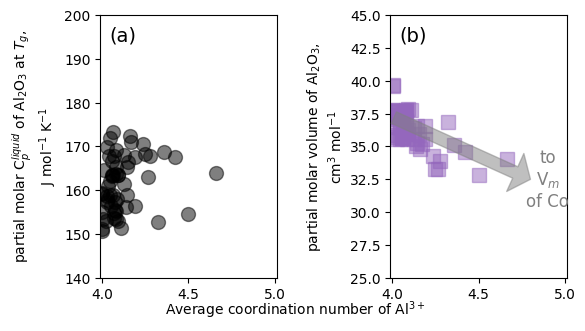

In [19]:
# We load the data
db_Al5_Ca = pd.read_excel("./data/Database.xlsx", sheet_name="CN_Al")
X_db_Al5_Ca = utils.descriptors(db_Al5_Ca.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo","cao"]]/100)
y_db_Al5_Ca = db_Al5_Ca.loc[:,["Al5"]].values
y_db_Al6_Ca = db_Al5_Ca.loc[:,["Al6"]].values
mean_db_Al_CN = (4*db_Al5_Ca.loc[:,["Al4"]].values/100
                +5*db_Al5_Ca.loc[:,["Al5"]].values/100
                +6*db_Al5_Ca.loc[:,["Al6"]].values/100)

# we predict the partial cpl for those compositions
partial_cpl_Al5_Ca = neuralmodel.predict("partial_cpl", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we also predict the partial molar volumes
partial_vm_Al5_Ca = neuralmodel.predict("vm_glass", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we calculate the Tg of the glasses
Tg_Al5_Ca = neuralmodel.predict("tg", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we calculate here the partial molar Cpl of Al2O3 at Tg
partial_cpl_Al2O3_Al5_Ca = partial_cpl_Al5_Ca[:,1,:] + partial_cpl_Al5_Ca[:,6,:]*Tg_Al5_Ca


# now we plot the fraction of Al5 in the glass
# against the partial cpl of Al2O3 at Tg
fig = plt.figure(figsize=(6,3.22))
ax1 = plt.subplot(1,2,1)
plt.plot(mean_db_Al_CN, partial_cpl_Al2O3_Al5_Ca.mean(axis=-1), "ko", ms=10, alpha=0.5)

plt.xlim(3.99,5.01)
plt.ylim(140,200)
plt.ylabel("partial molar C$_p^{liquid}$ of Al$_2$O$_3$ at $T_g$,\nJ mol$^{-1}$ K$^{-1}$")

plt.annotate("(a)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=14)

ax2 = plt.subplot(1,2,2)
plt.plot(mean_db_Al_CN, partial_vm_Al5_Ca[:,1,:].mean(axis=-1), "s", ms=10, color="C4", alpha=0.5)

plt.annotate("", xy=(4.8, 32.5), xytext=(4.01, 37.2), xycoords="data",
            arrowprops=dict(linestyle="-", 
                            width = 9, headwidth=30, color="grey", alpha=0.5), va="center")

plt.annotate("to\nV$_m$\nof Co", xy=(4.9, 32.5), xycoords="data", color="grey", 
             ha="center", va="center", fontsize=12)

plt.xlim(3.99,5.01)
plt.ylim(25,45)

plt.annotate("(b)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=14)

fig.text(x=0.5,y=0.005,s="Average coordination number of Al$^{3+}$", ha="center")
plt.ylabel("partial molar volume of Al$_2$O$_3$,\ncm$^3$ mol$^{-1}$")

plt.tight_layout()
plt.savefig("./figures/manuscript/Figure8.pdf")
